## Circuit cutting with automatic cut finding

###### Import the circuit we wish to cut, the necessary Runtime objects, and the WireCutter

In [17]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Options,
)

from circuit_knitting_toolbox.circuit_cutting import WireCutter

##### Parametrize the circuit and visualize it

In [18]:
num_qubits = 8
circuit = EfficientSU2(
    num_qubits=num_qubits,
    reps=2,
    entanglement="linear",
    su2_gates=["ry"],
    insert_barriers=False,
)

circuit = circuit.decompose()

params = [(np.pi * i) / 16 for i in range(len(circuit.parameters))]
circuit = circuit.bind_parameters(params)
circuit.draw(fold=300)

┌─────────┐      ┌─────────┐                           ┌───────┐                                                                                                                            
q_0: ─┤ Ry(0.0) ├───■──┤ Ry(π/2) ├──────────────────■────────┤ Ry(π) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├─────────┴┐┌─┴─┐└─────────┘┌───────────┐   ┌─┴─┐      └───────┘   ┌──────────────────────┐                                                                                                 
q_1: ─┤ Ry(π/16) ├┤ X ├─────■─────┤ Ry(9π/16) ├───┤ X ├──────────■───────┤ Ry(3.33794219443916) ├─────────────────────────────────────────────────────────────────────────────────────────────────
      ├─────────┬┘└───┘   ┌─┴─┐   └───────────┘┌──┴───┴───┐    ┌─┴─┐     └──────────────────────┘ ┌──────────┐                                                                                    
q_2: ─┤ Ry(π/8) ├─────────┤ X ├─────────■──────┤ Ry(5π/8) ├────┤ X ├────────────────■─────────────┤ Ry(9π/8) ├────────────────────────────────────────────────────────────────────────────────────
     ┌┴─────────┴┐        └───┘       ┌─┴─┐    └──────────┘┌───┴───┴────┐         ┌─┴─┐           └──────────┘ ┌──────────────────────┐                                                           
q_3: ┤ Ry(3π/16) ├────────────────────┤ X ├─────────■──────┤ Ry(11π/16) ├─────────┤ X ├────────────────■───────┤ Ry(3.73064127613788) ├───────────────────────────────────────────────────────────
     └┬─────────┬┘                    └───┘       ┌─┴─┐    └────────────┘      ┌──┴───┴───┐          ┌─┴─┐     └──────────────────────┘┌──────────┐                                               
q_4: ─┤ Ry(π/4) ├─────────────────────────────────┤ X ├──────────■─────────────┤ Ry(3π/4) ├──────────┤ X ├────────────────■────────────┤ Ry(5π/4) ├───────────────────────────────────────────────
     ┌┴─────────┴┐                                └───┘        ┌─┴─┐           └──────────┘      ┌───┴───┴────┐         ┌─┴─┐          └──────────┘┌─────────────────────┐                        
q_5: ┤ Ry(5π/16) ├─────────────────────────────────────────────┤ X ├────────────────■────────────┤ Ry(13π/16) ├─────────┤ X ├───────────────■──────┤ Ry(4.1233403578366) ├────────────────────────
     └┬──────────┤                                             └───┘              ┌─┴─┐          └────────────┘      ┌──┴───┴───┐         ┌─┴─┐    └─────────────────────┘     ┌───────────┐      
q_6: ─┤ Ry(3π/8) ├────────────────────────────────────────────────────────────────┤ X ├────────────────■─────────────┤ Ry(7π/8) ├─────────┤ X ├───────────────■────────────────┤ Ry(11π/8) ├──────
     ┌┴──────────┤                                                                └───┘              ┌─┴─┐          ┌┴──────────┴┐        └───┘             ┌─┴─┐         ┌────┴───────────┴─────┐
q_7: ┤ Ry(7π/16) ├───────────────────────────────────────────────────────────────────────────────────┤ X ├──────────┤ Ry(15π/16) ├──────────────────────────┤ X ├─────────┤ Ry(4.51603943953533) ├
     └───────────┘                                                                                   └───┘          └────────────┘                          └───┘         └──────────────────────┘

##### Set up the runtime service in order to use runtime backends. Otherwise, a local statevector simulator will be used

In [19]:
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="<YOUR_API_TOKEN>",
)

##### Set up the WireCutter. We will use 2 parallel runtime qasm simulators.
 * If only a circuit is passed to WireCutter, a local statevector simulator will be used to evaluate the subcircuits.

In [20]:
# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

# Instantiate a WireCutter and decompose the circuit
cutter = WireCutter(
    circuit, service=service, backend_names=backend_names, options=options
)
# cutter = WireCutter(circuit) # local Estimator

##### Find cuts that match our criteria
   * Use a mixed integer programming (MIP) model to find cuts automatically
   * Only allow subcircuits which are 6 qubits or less
   * Cut the circuit no more than two times
   * Allow no more than 2 subcircuits

In [21]:
cuts = cutter.decompose(
    method="automatic",
    max_subcircuit_width=6,
    max_cuts=2,
    num_subcircuits=[2],
)

(cut_circuit_wires pid=36158) Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
(cut_circuit_wires pid=36158) Version identifier: 22.1.0.0 | 2022-03-27 | 54982fbec
(cut_circuit_wires pid=36158) CPXPARAM_Read_DataCheck                          1
(cut_circuit_wires pid=36158) CPXPARAM_TimeLimit                               300
(cut_circuit_wires pid=36158) Warning:  Non-integral bounds for integer variables rounded.
(cut_circuit_wires pid=36158) Tried aggregator 3 times.
(cut_circuit_wires pid=36158) MIP Presolve eliminated 37 rows and 8 columns.
(cut_circuit_wires pid=36158) MIP Presolve modified 7 coefficients.
(cut_circuit_wires pid=36158) Aggregator did 103 substitutions.
(cut_circuit_wires pid=36158) Reduced MIP has 366 rows, 127 columns, and 1072 nonzeros.
(cut_circuit_wires pid=36158) Reduced MIP has 121 binaries, 6 generals, 0 SOSs, and 0 indicators.
(cut_circuit_wires pid=36158) Presolve time = 0.00 sec. (2.10 ticks)
(cut_circuit_wires

##### Evaluate the subcircuits on the backend
 * Two local cores will be used to support each of the parallel backend threads

In [22]:
# Evaluate the subcircuits on backend
subcircuit_instance_probabilities = cutter.evaluate(cuts)

##### Reconstruct the results of the subcircuit experiments into an estimate of the original circuit's full probability distribution

In [23]:
%%capture

reconstructed_probabilities = cutter.reconstruct(
    subcircuit_instance_probabilities, cuts
)

##### If the original circuit is small enough, we can use a statevector simulator to check the results of cutting against the original circuit's true probability distribution

In [24]:
metrics = cutter.verify(reconstructed_probabilities)
metrics

{'nearest': {'chi2': 0.013095714819861893,
  'Mean Squared Error': 3.640623142478008e-07,
  'Mean Absolute Percentage Error': 178.9089934317131,
  'Cross Entropy': 3.6518680272822097,
  'HOP': 0.9941571373310809},
 'naive': {'chi2': 0.013077969789597901,
  'Mean Squared Error': 3.7061392369384847e-07,
  'Mean Absolute Percentage Error': 896.5200170881297,
  'Cross Entropy': 3.645857452378845,
  'HOP': 0.9931801646787619}}

##### If we calculated the true probabilities, we can visualize the estimated and true probabilities together and compare

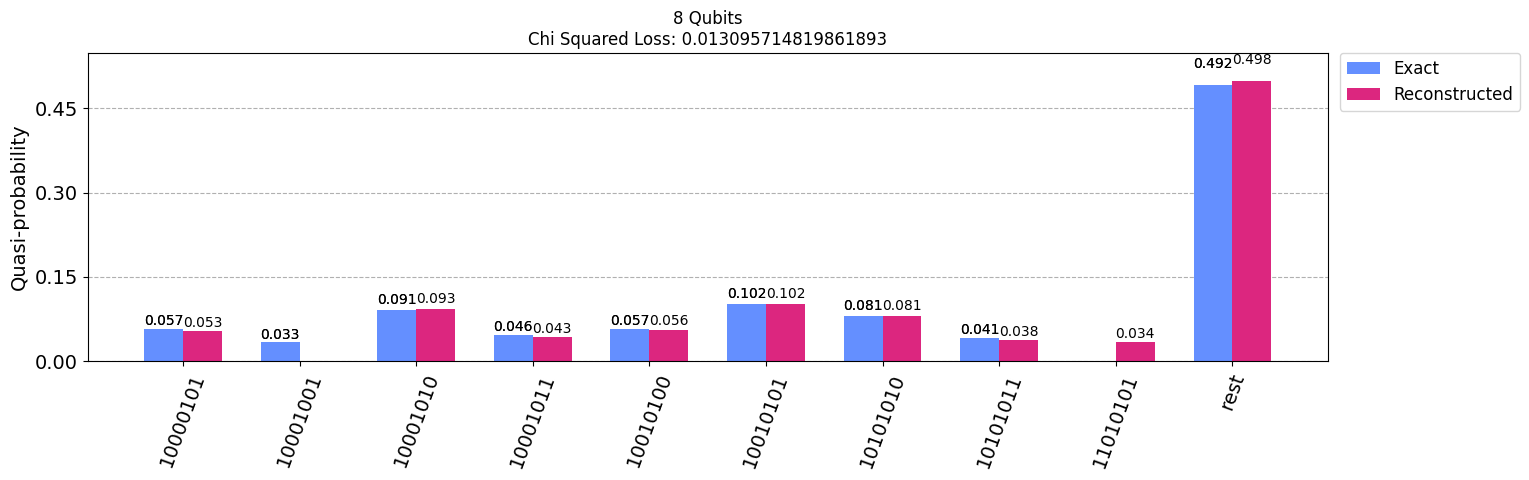

In [25]:
from qiskit import Aer
from qiskit.result import ProbDistribution
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

# Get the estimated distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Get the true distribution
simulator = Aer.get_backend("statevector_simulator")
result = simulator.run(circuit).result()
statevector = result.get_statevector(circuit)
true_distribution = {
    i: prob for i, prob in enumerate(Statevector(statevector).probabilities())
}

true_dict_bitstring = ProbDistribution(data=true_distribution).binary_probabilities(
    num_bits=num_qubits
)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)

plot_histogram(
    [true_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 4),
    sort="asc",
    legend=["Exact", "Reconstructed"],
    title="{} Qubits\nChi Squared Loss: {}".format(
        num_qubits, metrics["nearest"]["chi2"]
    ),
)